In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import h5py

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler

device = "cuda" if torch.cuda.is_available() else "cpu"

class LSTMBinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, kernel_size=7):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.conv = nn.Conv1d(input_size, hidden_size, kernel_size=kernel_size, padding=1)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size // 4)  # *2 из-за bidirectional LSTM
        self.l_relu = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_size // 4, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.batch_norm(x)
        x = x.permute(0, 2, 1)

        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc1(out)
        out = self.l_relu(out)
        out = self.fc2(out)
        return out


def load_data(metadata_filepath, sample_freq, N_start=0, N_end=10, only_health=False):
    metadata_full = pd.read_csv(metadata_filepath)
    metadata = metadata_full.iloc[N_start:N_end]

    metadata = metadata.drop(columns=['Date', 'Patient_ID'])
    metadata['Age'] = metadata['Age'].astype(np.int32)
    metadata['N'] = metadata['N'].astype(np.int32)

    if only_health:
        health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
    else:
        health_metadata = metadata

    id_metadata = health_metadata['ECG_ID'].values
    labels = health_metadata['AHA_Code'].astype(str).values

    signals = []
    for i in id_metadata:
        with h5py.File(f'/kaggle/input/ecgdata/records/{i}.h5', 'r') as f:
            signals.append(f['ecg'][()])

    health_n = (labels == '1').sum()
    diseased_n = (labels != '1').sum()
    print(f"Data loaded successfully.\nHealth: {health_n}, Diseased: {diseased_n}\n")
    return signals, labels


def signal_transform_tensor_12_scaled(signals, max_len_signal=5000):
    scaler = MinMaxScaler()
    flattened_signals = np.concatenate([np.array(signal).flatten() for signal in signals])
    scaler.fit(flattened_signals.reshape(-1, 1))

    results_reshape = []
    for i in range(12):
        s = [scaler.transform(np.array(signal[i][0:max_len_signal]).reshape(-1, 1)).flatten() for signal in signals]
        results_reshape.append(np.array(s).reshape(1, max_len_signal * len(signals)))

    result_reshape = np.concatenate(results_reshape)
    return torch.tensor(result_reshape, dtype=torch.float32).reshape((12, len(signals), max_len_signal)).permute((1, 2, 0))


def label_transform_tensor(labels):
    result_labels = np.where(labels.astype(str) == '1', 0, 1)
    return torch.tensor(result_labels, dtype=torch.float32).reshape(-1, 1)


def pipeline_0_model_iteration(N, save_weights_name, num_epochs=100, lr=0.01, momentum=0.9, plot=False):
    metadata_filepath = '/kaggle/input/metadata/metadata.csv'
    sample_freq = 500

    signals, labels = load_data(metadata_filepath, sample_freq, N_end=N)
    X = signal_transform_tensor_12_scaled(signals).to(device)
    y = label_transform_tensor(labels).to(device)

    dataset = TensorDataset(X, y)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    input_size = 12
    hidden_size = 50
    output_size = 1
    num_layers = 1

    model = LSTMBinaryClassifier(input_size, hidden_size, output_size, num_layers).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    print("Training model...\n")
    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for batch_x, batch_y in progress_bar:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            accuracy = (outputs.round() == batch_y).float().mean()
            progress_bar.set_postfix({"Loss": f"{loss.item():.4f}", "Accuracy": f"{accuracy.item():.4f}"})

    print("Evaluating model...\n")
    model.eval()
    correct, total = 0, 0

    if plot:
        plt.figure(figsize=(10, 6))

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            predicted = (outputs > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

            if plot:
                plt.plot(batch_y.cpu().numpy(), label='True Labels', marker='o', linestyle='None')
                plt.plot(predicted.cpu().numpy(), label='Predicted Labels', marker='x', linestyle='None')

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    if plot:
        plt.legend()
        plt.show()

    torch.save(model.state_dict(), save_weights_name)
    return model


if __name__ == '__main__':
    save_path = '12_2048_SGD_10_0.0001_0.9_0.pth'
    pipeline_0_model_iteration(2048, save_path, lr=0.0001, momentum=0.9, plot=False)


Data loaded successfully.
Health: 1067, Diseased: 981

Training model...




Epoch 1/100: 100%|██████████| 52/52 [00:02<00:00, 23.84batch/s, Loss=0.6919, Accuracy=0.3333]

Epoch 2/100: 100%|██████████| 52/52 [00:02<00:00, 25.06batch/s, Loss=0.6599, Accuracy=0.8333]

Epoch 3/100: 100%|██████████| 52/52 [00:02<00:00, 24.99batch/s, Loss=0.6941, Accuracy=0.3333]

Epoch 4/100: 100%|██████████| 52/52 [00:02<00:00, 25.06batch/s, Loss=0.6978, Accuracy=0.5000]

Epoch 5/100: 100%|██████████| 52/52 [00:02<00:00, 25.03batch/s, Loss=0.6902, Accuracy=0.5000]

Epoch 6/100: 100%|██████████| 52/52 [00:02<00:00, 25.03batch/s, Loss=0.7300, Accuracy=0.1667]

Epoch 7/100: 100%|██████████| 52/52 [00:02<00:00, 24.98batch/s, Loss=0.7218, Accuracy=0.0000]

Epoch 8/100: 100%|██████████| 52/52 [00:02<00:00, 24.84batch/s, Loss=0.6980, Accuracy=0.5000]

Epoch 9/100: 100%|██████████| 52/52 [00:02<00:00, 25.02batch/s, Loss=0.6921, Accuracy=0.3333]

Epoch 10/100: 100%|██████████| 52/52 [00:02<00:00, 24.95batch/s, Loss=0.7149, Accuracy=0.3333]

Epoch 11/100: 100%|██████████| 52/52 [00:02<00:0

In [ ]:
import gc

save_path = './12_2048_SGD_10_0.0001_0.9_0.pth'

gc.collect()

pipeline_0_model_iteration(10000, save_path, lr=0.0001, momentum=0.9, plot=False)

torch.cuda.empty_cache()

Data loaded successfully.
          Health    number:     5360
          Diseased  number:     4640




In [27]:

import h5py

In [18]:

N = 4
with h5py.File(f'/kaggle/input/ecgdata/records/A{N:05d}.h5', 'r') as f:
 signal = f['ecg'][()]
 print('The size of record: {}'.format(signal.shape))

The size of record: (12, 5000)


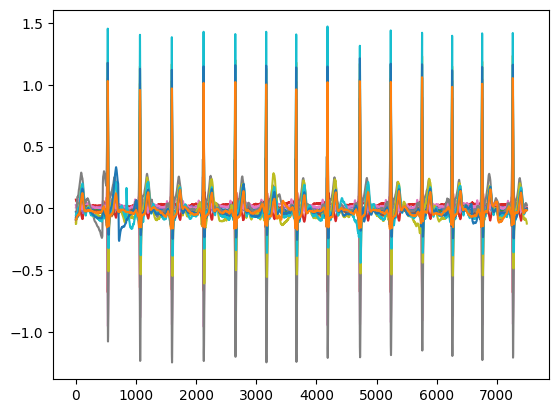

In [29]:
import matplotlib.pyplot as plt
# plot the signal
for i in range(12):
 plt.plot(signal[i])

In [30]:
import pandas as pd
df = pd.read_csv('/kaggle/input/metadata/metadata.csv');

In [31]:
def remove_nonprimary_code(x):
    r = []
    for cx in x:
     for c in cx.split('+'):
         if int(c) < 200 or int(c) >= 500:
             if c not in r:
                 r.append(c)
     return r

In [32]:
codes = df.AHA_Code.str.split(';')
primary_codes = codes.apply(remove_nonprimary_code)

In [33]:
# get the diagnosis
desc = pd.read_csv('/kaggle/input/metadata/code.csv')
print('The diagnosis:')
for c in primary_codes[N-1]:
 print(desc[desc.Code == int(c)].Description.iloc[0])

The diagnosis:
Normal ECG


In [34]:
from numpy.fft import fft, fftshift, fftfreq
import numpy as np

In [35]:
def SQI(ecg_lead):
     """Return basSQI and pSQI of an ECG lead."""
     L = ecg_lead.size
     fs = 500
     freq = fftshift(fftfreq(L, 1/fs))
     amp = fftshift(np.abs(fft(ecg_lead)/L))
     ind = round(amp.size/2 - 0.5)
     amp[ind+1:] *= 2
     freq = freq[ind:]
     amp = amp[ind:]
     # basSQI
     s = np.sum(amp[freq<=40]**2)
     s2 = np.sum(amp[freq<=1]**2)
     bas = 1-s2/s
     # pSQI
     s = np.sum(amp[(freq<=40)&(freq>=5)]**2)
     s2 = np.sum(amp[(freq<=15)&(freq>=5)]**2)
     p = s2/s
     return bas, p


def average_quality(signal):
     """Return the average basSQI and pSQI of a 12-lead ECG signal."""
     bas = p = 0
     for i in range(12):
         r1, r2 = SQI(signal[i])
         bas += r1
         p += r2
     return bas/12, p/12

In [36]:
def ecg_train_test_split(df):
 # put all records belonging to patients with
 # multiple records in the test set
 test1 = df.Patient_ID.duplicated(keep=False)
 N = int(len(df)*0.2) - sum(test1)
 # 73 is chosen such that all primary statements exist in both sets
 df_test = pd.concat([df[test1], df[~test1].sample(N, random_state=73)])
 df_train = df.iloc[df.index.difference(df_test.index)]
 return df_train, df_test
df_train, df_test = ecg_train_test_split(df)
print(f'The training set has {len(df_train)} records')
print(f'The test set has {len(df_test)} records')

The training set has 20616 records
The test set has 5154 records


In [37]:
df_train

,ECG_ID,AHA_Code,Patient_ID,Age,Sex,N,Date
0,A00001,22;23,S00001,55,M,5000,2020-03-04
1,A00002,1,S00002,32,M,6000,2019-09-03
2,A00003,1,S00003,63,M,6500,2020-07-16
3,A00004,23,S00004,31,M,5000,2020-07-14
4,A00005,146,S00005,47,M,5500,2020-01-07
...,...,...,...,...,...,...,...
25764,A25765,1,S24661,52,F,5000,2019-08-26
25765,A25766,146,S24662,33,F,5000,2020-03-22
25766,A25767,23,S24663,37,F,5000,2020-03-01
25768,A25769,22;147,S24665,65,M,5000,2020-01-19


In [25]:
desc

,Category,Code,Description
0,A,1,Normal ECG
1,C,21,Sinus tachycardia
2,C,22,Sinus bradycardia
3,C,23,Sinus arrhythmia
4,D,30,Atrial premature complex(es)
5,D,31,"Atrial premature complexes, nonconducted"
6,D,36,Junctional premature complex(es)
7,D,37,Junctional escape complex(es)
8,E,50,Atrial fibrillation
9,E,51,Atrial flutter


In [26]:
df

,ECG_ID,AHA_Code,Patient_ID,Age,Sex,N,Date
0,A00001,22;23,S00001,55,M,5000,2020-03-04
1,A00002,1,S00002,32,M,6000,2019-09-03
2,A00003,1,S00003,63,M,6500,2020-07-16
3,A00004,23,S00004,31,M,5000,2020-07-14
4,A00005,146,S00005,47,M,5500,2020-01-07
...,...,...,...,...,...,...,...
25765,A25766,146,S24662,33,F,5000,2020-03-22
25766,A25767,23,S24663,37,F,5000,2020-03-01
25767,A25768,147,S24664,56,F,5000,2020-06-07
25768,A25769,22;147,S24665,65,M,5000,2020-01-19


Epoch [1/20], Loss: 0.0658
Epoch [2/20], Loss: 0.0201
Epoch [3/20], Loss: 0.0150
Epoch [4/20], Loss: 0.0183
Epoch [5/20], Loss: 0.0074
Epoch [6/20], Loss: 0.0096
Epoch [7/20], Loss: 0.0076
Epoch [8/20], Loss: 0.0073
Epoch [9/20], Loss: 0.0030
Epoch [10/20], Loss: 0.0088
Epoch [11/20], Loss: 0.0079
Epoch [12/20], Loss: 0.0036
Epoch [13/20], Loss: 0.0062
Epoch [14/20], Loss: 0.0064
Epoch [15/20], Loss: 0.0019
Epoch [16/20], Loss: 0.0031
Epoch [17/20], Loss: 0.0034
Epoch [18/20], Loss: 0.0019
Epoch [19/20], Loss: 0.0039
Epoch [20/20], Loss: 0.0017


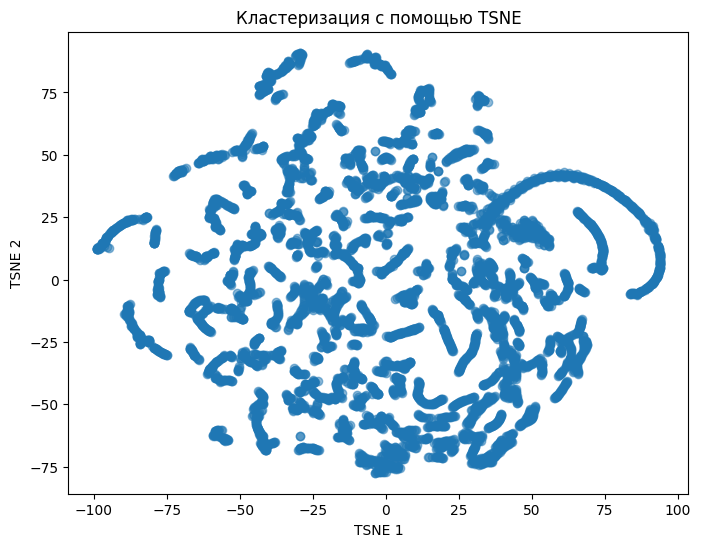

In [39]:
import h5py
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

scaler = StandardScaler()
signal = scaler.fit_transform(signal.T).T  # Нормализация по каналам

# ==== 2. Создаем Dataset и DataLoader ====
class ECGDataset(Dataset):
    def __init__(self, signal):
        self.data = torch.tensor(signal, dtype=torch.float32)

    def __len__(self):
        return self.data.shape[1]  # Количество временных точек

    def __getitem__(self, idx):
        return self.data[:, idx]  # Берем все 12 каналов в одной временной точке

dataset = ECGDataset(signal)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# ==== 3. Определяем автоэнкодер ====
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8)  # Скрытое представление размером 8
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 12)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# ==== 4. Обучение автоэнкодера ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        decoded, _ = model(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# ==== 5. Кластеризация с помощью TSNE ====
all_encoded = []
with torch.no_grad():
    for batch in dataloader:
        batch = batch.to(device)
        _, encoded = model(batch)
        all_encoded.append(encoded.cpu().numpy())

all_encoded = np.vstack(all_encoded)

# TSNE для уменьшения размерности (из 8D в 2D)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedded = tsne.fit_transform(all_encoded)

# Визуализация
plt.figure(figsize=(8, 6))
plt.scatter(embedded[:, 0], embedded[:, 1], alpha=0.5)
plt.title("Кластеризация с помощью TSNE")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.show()

In [2]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.9 MB/s eta 0:00:00


In [2]:
import h5py
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

# ==== 1. Загрузка данных ====


# with h5py.File(f'/kaggle/input/ecgdata/records/A{N:05d}.h5', 'r') as f:
#     signal = f['ecg'][()]  # (12, 7500)


# ==== 2. Dataset и DataLoader ====
class ECGDataset(Dataset):
    def __init__(self, signals, labels):
        self.data = torch.tensor(signals, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.int64)

    def __len__(self):
        return self.data.shape[0]  # Количество пациентов

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = ECGDataset(all_signals, all_labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
# ==== 3. Автоэнкодер ====
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(12 * 7500, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 8)  # Скрытое представление
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(),
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 12 * 7500)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# ==== 4. Обучение ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    for batch, _ in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        decoded, _ = model(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# ==== 5. Кластеризация с UMAP ====
all_encoded = []
all_labels = []

with torch.no_grad():
    for batch, labels in dataloader:
        batch = batch.to(device)
        _, encoded = model(batch)
        all_encoded.append(encoded.cpu().numpy())
        all_labels.append(labels.numpy())

all_encoded = []
all_labels_list = []

with torch.no_grad():
    for batch, labels in dataloader:
        batch = batch.view(batch.size(0), -1).to(device)
        _, encoded = model(batch)
        all_encoded.append(encoded.cpu().numpy())
        all_labels_list.append(labels.numpy())

all_encoded = np.vstack(all_encoded)
all_labels_list = np.hstack(all_labels_list)

# UMAP (из 8D в 2D)
umap_model = umap.UMAP(n_components=2, random_state=42)
embedded_umap = umap_model.fit_transform(all_encoded)

# Визуализация UMAP
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedded_umap[:, 0], y=embedded_umap[:, 1], hue=all_labels_list, palette={0: "red", 1: "green"}, alpha=0.6)
plt.title("Кластеризация UMAP (красные - больные, зеленые - здоровые)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

# ==== 7. TSNE ====
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedded_tsne = tsne.fit_transform(all_encoded)

# Визуализация TSNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedded_tsne[:, 0], y=embedded_tsne[:, 1], hue=all_labels_list, palette={0: "red", 1: "green"}, alpha=0.6)
plt.title("Кластеризация TSNE (красные - больные, зеленые - здоровые)")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.show()


NameError: name 'all_signals' is not defined

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
from glob import glob
import scipy.signal as signal
from scipy.signal import find_peaks, savgol_filter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader

def ultra_filter(y):
    """Фильтрация ЭКГ с использованием метода Савицкого-Голея и поиска пиков."""
    x = np.linspace(0, len(y) - 1, len(y))

    # Найдем пики
    peaks, _ = find_peaks(y, height=(0.1, 0.5), distance=10)
    peaks = peaks[peaks < len(y)]

    # Найдем тренд с помощью фильтра Савицкого-Голея
    y_trend = savgol_filter(y, window_length=51, polyorder=3)

    # Удалим тренд, чтобы получить колебания (пики и волны)
    y_fluctuations = y - y_trend

    # Обработаем волны (сгладим их)
    y_waves_smoothed = savgol_filter(y_fluctuations, window_length=21, polyorder=2)

    # Восстановим данные, добавив колебания к тренду
    y_restored = y_trend + y_waves_smoothed

    return y_restored

# Загрузка метаданных
df = pd.read_csv('/kaggle/input/metadata/metadata.csv')
df['Sex'] = df['Sex'].map({'F': 0, 'M': 1})

# Нормализуем возраст (MinMax от 0 до 1)
age_scaler = MinMaxScaler()
df['Age'] = age_scaler.fit_transform(df[['Age']])

healthy_code = '1'
df['label'] = (df['AHA_Code'] == healthy_code).astype(int)

num_records = 10000
fixed_length = 7500
all_signals = np.zeros((num_records, 12, fixed_length), dtype=np.float32)
all_labels = np.zeros(num_records, dtype=np.int64)
all_metadata = np.zeros((num_records, 2), dtype=np.float32)

for idx, row in df.iterrows():
    if idx % 100 == 0:
        print(idx)
    if idx == num_records:
        break

    ecg_id = row['ECG_ID']
    label = row['label']
    sex = row['Sex']
    age = row['Age']

    with h5py.File(f'/kaggle/input/ecgdata/records/{ecg_id}.h5', 'r') as f:
        signal_data = f['ecg'][()]

    if signal_data.shape[1] < fixed_length:
        padding = np.zeros((12, fixed_length - signal_data.shape[1]))
        signal_data = np.hstack((signal_data, padding))
    elif signal_data.shape[1] > fixed_length:
        signal_data = signal_data[:, :fixed_length]

    # Применение нового фильтра
    for lead in range(12):
        signal_data[lead] = ultra_filter(signal_data[lead])

    all_signals[idx] = signal_data
    all_labels[idx] = label
    all_metadata[idx] = [sex, age]


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [3]:
class ECGDataset(Dataset):
    def __init__(self, signals, labels, metadata):
        self.data = torch.tensor(signals, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.int64)
        self.metadata = torch.tensor(metadata, dtype=torch.float32)  

    def __len__(self):
        return self.data.shape[0]  #

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.metadata[idx] 

dataset = ECGDataset(all_signals, all_labels, all_metadata)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print("✅ Датасет создан, готов к обучению модели!")

✅ Датасет создан, готов к обучению модели!


In [5]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for batch, labels, metadata in dataloader: 
        batch = batch.to(device)
        if torch.isnan(batch).any() or torch.isinf(batch).any():
            print(f"⚠️ Найдены NaN/inf в batch на эпохе {epoch + 1}, пропускаем...")
            continue
        optimizer.zero_grad()
        
        decoded, _ = model(batch)  
        loss = criterion(decoded, batch)  
        
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0049
Epoch [2/10], Loss: 0.0099
Epoch [3/10], Loss: 0.0033
Epoch [4/10], Loss: 0.0044
Epoch [5/10], Loss: 0.0052
Epoch [6/10], Loss: 0.0344
Epoch [7/10], Loss: 0.0092
Epoch [8/10], Loss: 0.0039
Epoch [9/10], Loss: 0.0035
Epoch [10/10], Loss: 0.0056


In [4]:
from torch import nn
class Autoencoder(nn.Module):
    def __init__(self, input_dim=7500, latent_dim=16):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=12, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=2, stride=2),  

            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=2, stride=2),  

            nn.Conv1d(128, latent_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(latent_dim),
            nn.MaxPool1d(kernel_size=2, stride=2)  
        )

        # === Decoder ===
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"), 
            nn.ConvTranspose1d(latent_dim, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Upsample(scale_factor=2, mode="nearest"), 
            nn.ConvTranspose1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Upsample(scale_factor=2, mode="nearest"),  
            nn.ConvTranspose1d(128, 12, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        if decoded.shape[2] != x.shape[2]:
            decoded = nn.functional.interpolate(decoded, size=x.shape[2], mode="linear", align_corners=False)

        return decoded, encoded

Размерность all_encoded: (10000, 16, 937)
Размерность all_encoded: (10000, 14992)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Adjusted Rand Index (сравнение с истинными метками): -0.0008


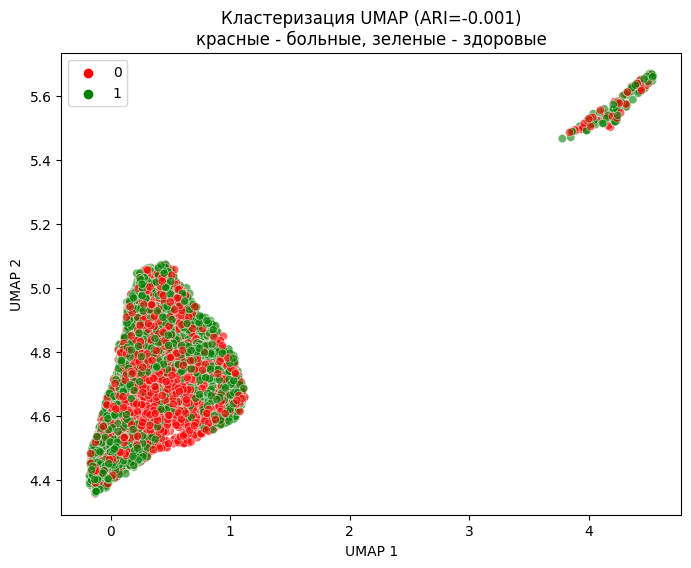

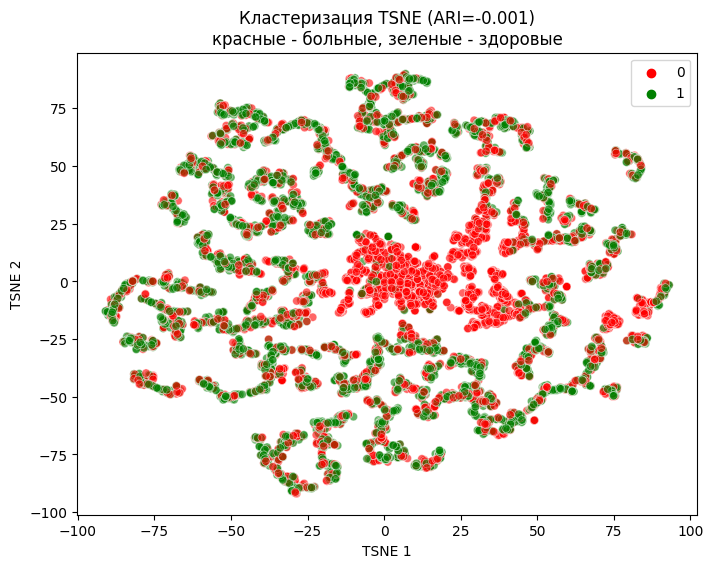

In [51]:
import umap
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

all_encoded = []
all_labels_list = []

with torch.no_grad():
    for batch, labels, meta in dataloader:
        batch = batch.to(device)
        _, encoded = model(batch)
        all_encoded.append(encoded.cpu().numpy())
        all_labels_list.append(labels.numpy())

all_encoded = np.vstack(all_encoded)
print(f"Размерность all_encoded: {all_encoded.shape}") 
all_labels_list = np.hstack(all_labels_list)

if all_encoded.ndim == 3:
    all_encoded = all_encoded.reshape(all_encoded.shape[0], -1)
print(f"Размерность all_encoded: {all_encoded.shape}") 

# Кластеризация KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(all_encoded)

# Вычисление Adjusted Rand Index
ari = adjusted_rand_score(all_labels_list, clusters)
print(f"\nAdjusted Rand Index (сравнение с истинными метками): {ari:.4f}")

# Визуализация UMAP
umap_model = umap.UMAP(n_components=12)
embedded_umap = umap_model.fit_transform(all_encoded)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedded_umap[:, 0], y=embedded_umap[:, 1], 
                hue=all_labels_list, palette={0: "red", 1: "green"}, 
                alpha=0.6)
plt.title(f"Кластеризация UMAP (ARI={ari:.3f})\nкрасные - больные, зеленые - здоровые")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

# Визуализация TSNE
tsne = TSNE(n_components=2, perplexity=30)
embedded_tsne = tsne.fit_transform(embedded_umap)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedded_tsne[:, 0], y=embedded_tsne[:, 1], 
                hue=all_labels_list, palette={0: "red", 1: "green"}, 
                alpha=0.6)
plt.title(f"Кластеризация TSNE (ARI={ari:.3f})\nкрасные - больные, зеленые - здоровые")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.show()

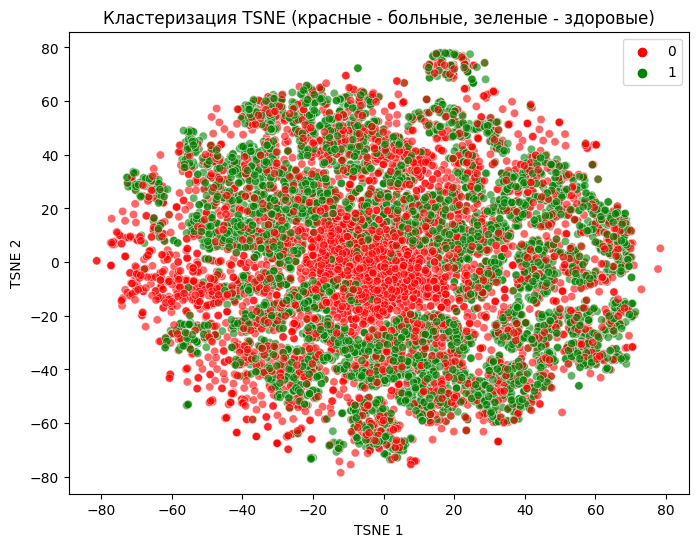

In [77]:
tsne = TSNE(n_components=2, perplexity=20)
embedded_tsne = tsne.fit_transform(all_encoded)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedded_tsne[:, 0], y=embedded_tsne[:, 1], hue=all_labels_list, palette={0: "red", 1: "green"}, alpha=0.6)
plt.title("Кластеризация TSNE (красные - больные, зеленые - здоровые)")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index: 0.005
Silhouette Score: 0.161


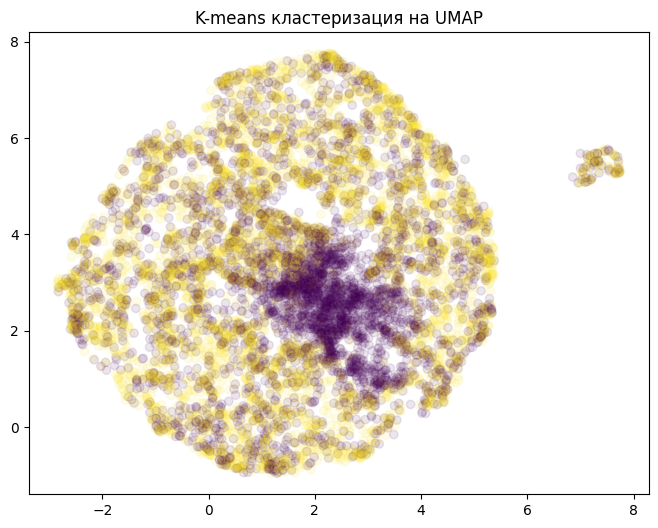

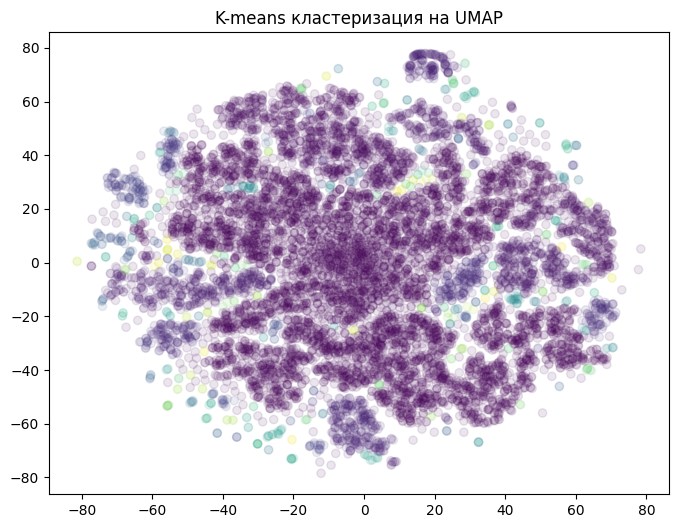

In [79]:
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.cluster import KMeans
# Пример кластеризации K-means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(embedded_tsne)
dbscan = DBSCAN(eps=2, min_samples=2)
dbscan_clusters = dbscan.fit_predict(embedded_tsne)

# Оценка
ari = adjusted_rand_score(all_labels_list, dbscan_clusters)
silhouette = silhouette_score(embedded_umap, kmeans.labels_)
print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Silhouette Score: {silhouette:.3f}")

# Визуализация кластеров K-means
plt.figure(figsize=(8, 6))
plt.scatter(embedded_umap[:, 0], embedded_umap[:, 1], c=all_labels_list, cmap='viridis', alpha=0.1)
plt.title("K-means кластеризация на UMAP")
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(embedded_tsne[:, 0], embedded_tsne[:, 1], c=dbscan_clusters, cmap='viridis', alpha=0.1)
plt.title("K-means кластеризация на UMAP")
plt.show()

Размерность all_encoded: (10000, 16, 937)
Размерность all_encoded: (10000, 14992)
Adjusted Rand Index (Bayesian GMM): -0.0012


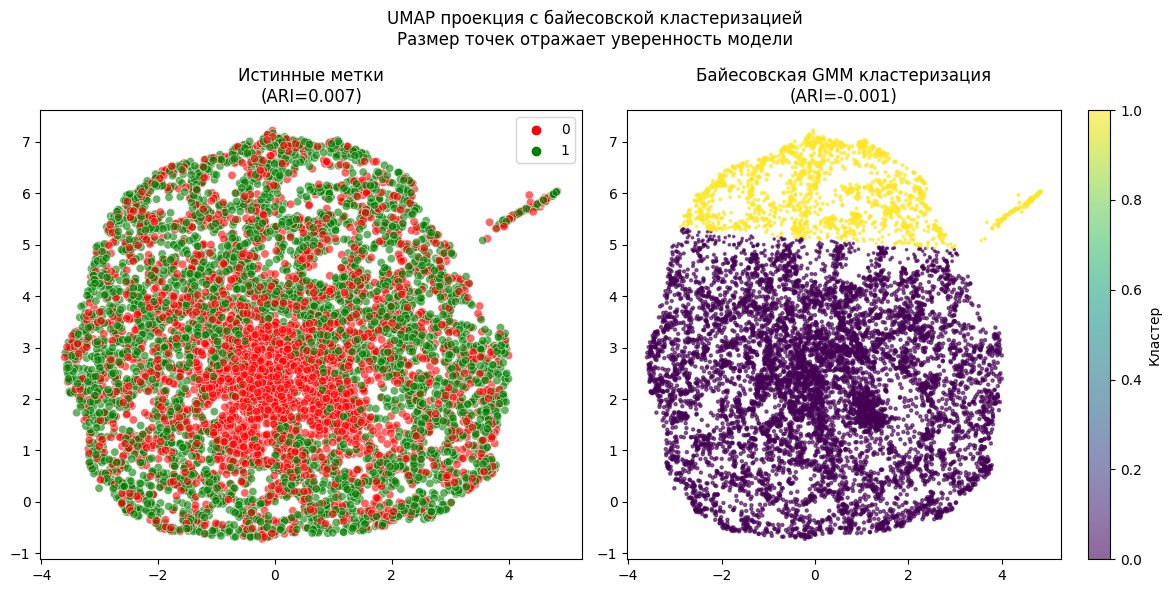

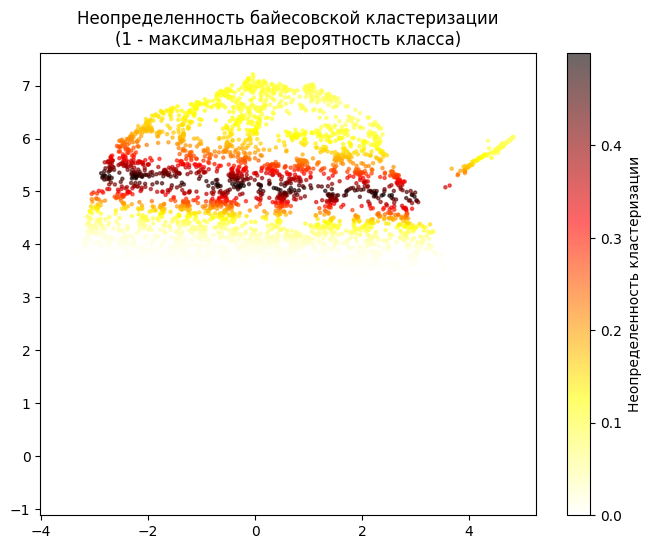

In [7]:
import umap
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture
import torch

all_encoded = []
all_labels_list = []

with torch.no_grad():
    for batch, labels, meta in dataloader:
        batch = batch.to(device)
        _, encoded = model(batch)
        all_encoded.append(encoded.cpu().numpy())
        all_labels_list.append(labels.numpy())

all_encoded = np.vstack(all_encoded)
print(f"Размерность all_encoded: {all_encoded.shape}") 
all_labels_list = np.hstack(all_labels_list)

if all_encoded.ndim == 3:
    all_encoded = all_encoded.reshape(all_encoded.shape[0], -1)
print(f"Размерность all_encoded: {all_encoded.shape}") 



umap_model = umap.UMAP(n_components=2)
embedded_umap = umap_model.fit_transform(all_encoded)


bgmm = BayesianGaussianMixture(
    n_components=2,
    weight_concentration_prior_type="dirichlet_process",
    weight_concentration_prior=0.1,
    max_iter=1000,
    n_init=5,
    random_state=42
)
bgmm.fit(embedded_umap)
bgmm_clusters = bgmm.predict(embedded_umap)
bgmm_probs = bgmm.predict_proba(embedded_umap)


uncertainty = 1 - np.max(bgmm_probs, axis=1)


bgmm_ari = adjusted_rand_score(all_labels_list, bgmm_clusters)
print(f"Adjusted Rand Index (Bayesian GMM): {bgmm_ari:.4f}")


plt.figure(figsize=(12, 6))

plt.subplot(121)
sns.scatterplot(
    x=embedded_umap[:, 0], y=embedded_umap[:, 1],
    hue=all_labels_list, palette={0: "red", 1: "green"},
    alpha=0.6
)
plt.title(f"Истинные метки\n(ARI={ari:.3f})")

plt.subplot(122)
scatter = plt.scatter(
    embedded_umap[:, 0], embedded_umap[:, 1],
    c=bgmm_clusters, cmap='viridis',
    alpha=0.6, s=5*(1-uncertainty) 
)
plt.colorbar(scatter, label='Кластер')
plt.title(f"Байесовская GMM кластеризация\n(ARI={bgmm_ari:.3f})")

plt.suptitle("UMAP проекция с байесовской кластеризацией\nРазмер точек отражает уверенность модели")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
uncertainty_scatter = plt.scatter(
    embedded_umap[:, 0], embedded_umap[:, 1],
    c=uncertainty, cmap='hot_r',
    alpha=0.6, s=5
)
plt.colorbar(uncertainty_scatter, label='Неопределенность кластеризации')
plt.title("Неопределенность байесовской кластеризации\n(1 - максимальная вероятность класса)")
plt.show()

In [64]:
umap_model = umap.UMAP(n_components=2)
embedded_umap = umap_model.fit_transform(all_encoded)

In [58]:

count_ones = sum(np.sum(arr == 1) for arr in all_labels)
print(count_ones)

2691


In [59]:
sum(all_labels)

2691

In [22]:
from scipy.signal import find_peaks, savgol_filter

def ultra_filter(signals, n, channel):
    y = signals[n][channel]
    x = np.linspace(0, len(y) - 1, len(y))

    # 1. Найдем пики
    peaks, _ = find_peaks(y, height=(0.1, 0.5), distance=10)  # Настройте параметры под ваши данные
    peaks = peaks[peaks < len(y)]

    # 2. Найдем тренд с помощью фильтра Савицкого-Голея
    y_trend = savgol_filter(y, window_length=51, polyorder=3)

    # 3. Удалим тренд, чтобы получить колебания (пики и волны)
    y_fluctuations = y - y_trend

    # 4. Обработаем волны (сгладим их)
    y_waves_smoothed = savgol_filter(y_fluctuations, window_length=21, polyorder=2)

    # 5. Восстановим данные, добавив колебания к тренду
    y_restored = y_trend + y_waves_smoothed